In [ ]:
!pip install --quiet transformers seaborn datasets evaluate rouge_score nltk numpy spacy lexrank

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.4 MB/s eta 0:00

In [ ]:
!pip install --quiet --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 15.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/RuSportSum/train_during_match_pairs_data3.csv" /content/train.csv
!cp "/content/drive/MyDrive/RuSportSum/eval_during_match_pairs_data3.csv" /content/eval.csv
!cp "/content/drive/MyDrive/RuSportSum/test_during_match_pairs_data3.csv" /content/test.csv
!cp "/content/drive/MyDrive/RuSportSum/summ_during_match.csv" /content/summ_during_match.csv

In [ ]:
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from lexrank import LexRank
from spacy.lang.ru.stop_words import STOP_WORDS

import nltk
from nltk.tokenize import sent_tokenize
import numpy as np
from datasets import Dataset
from datasets import load_dataset, load_metric
from sklearn.model_selection import train_test_split
import transformers
from transformers import (
    AutoConfig,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    HfArgumentParser,
    MBart50TokenizerFast,
    MBartTokenizer,
    MBartTokenizerFast,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    set_seed,
)
import evaluate

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
train = pd.read_csv('/content/train.csv')
eval = pd.read_csv('/content/eval.csv')
test = pd.read_csv('/content/test.csv')

summ_during_match = pd.read_csv('/content/summ_during_match.csv')

train

,match_id,news_id,name,team1,team2,relevant_part,type,minute,content,news_name_body
0,479927,149901417,Квалификация ЧМ: Европа,Португалия,Россия,0,empty,0,0 минута. Всем привет! Непобедимая сборная Рос...,Португалия – Россия. Акинфеев установил рекорд...
1,479927,149901417,Квалификация ЧМ: Европа,Португалия,Россия,0,empty,0,0 минута. Не все верят в непобедимость сборной...,Португалия – Россия. Акинфеев установил рекорд...
2,479927,149901417,Квалификация ЧМ: Европа,Португалия,Россия,0,empty,0,"0 минута. Первый, московский, матч соперников ...",Португалия – Россия. Акинфеев установил рекорд...
3,479927,149901417,Квалификация ЧМ: Европа,Португалия,Россия,0,empty,0,0 минута. Вот так было дело.,Португалия – Россия. Акинфеев установил рекорд...
4,479927,149901417,Квалификация ЧМ: Европа,Португалия,Россия,0,empty,0,0 минута.,Португалия – Россия. Акинфеев установил рекорд...
...,...,...,...,...,...,...,...,...,...,...
283352,519191,146265980,КХЛ,Динамо Москва,СКА,0,empty,60,60 минута. 1:2 - Ежов остался-таки без шатаута...,«Динамо» – СКА. Яласваара госпитализирован & З...
283353,519191,146265980,КХЛ,Динамо Москва,СКА,0,empty,60,60 минута. Лидерами по игровому времени стали ...,«Динамо» – СКА. Яласваара госпитализирован & З...
283354,519191,146265980,КХЛ,Динамо Москва,СКА,0,empty,60,"60 минута. Всего вам доброго, спасибо за участ...",«Динамо» – СКА. Яласваара госпитализирован & З...
283355,519191,146265980,КХЛ,Динамо Москва,СКА,0,empty,60,60 минута. СКА зарабатывает три очка и выходит...,«Динамо» – СКА. Яласваара госпитализирован & З...


In [ ]:
def concatenate_content(messages):
  return ' '.join([str(message).strip() for message in messages])

summ_during_match = summ_during_match[summ_during_match['relevant_part'] == 1]
summ_during_match.drop(['relevant_part', 'type'], axis=1, inplace=True)


grouping_columns = ['match_id', 'news_id', 'name', 'team1', 'team2', 'news_name_body']
summ_during_match = summ_during_match.sort_values(['match_id', 'news_id', 'minute'], ascending = True).groupby(grouping_columns)['content'].apply(concatenate_content).reset_index()
summ_during_match

,match_id,news_id,name,team1,team2,news_name_body,content
0,18925,7274151,Россия. Премьер-лига,Локомотив,Химки,Дюрица получил травму в игре с «Химками» & Защ...,0 минута. Добрый день! Sports.ru поздравляет в...
1,18925,7274964,Россия. Премьер-лига,Локомотив,Химки,Антипенко получил травму в матче с «Локомотиво...,0 минута. Добрый день! Sports.ru поздравляет в...
2,18935,7014478,перенесенные матчи,Зенит,Штутгарт,Хусти забил в первом официальном матче в соста...,0 минута. Но были у питерской команды и приобр...
3,18956,7114149,перенесенные матчи,Штутгарт,Зенит,Семшов забил первый гол в составе «Зенита» & П...,41 минута. гол!!! Семшов слета замыкает подачу...
4,18984,22193831,Россия. Премьер-лига,Химки,Динамо,Агьяр забил в дебютном матче в составе «Динамо...,0 минута. Привет! Второй матч воскресного дня ...
...,...,...,...,...,...,...,...
4005,1101632,1040297619,Чемпионат мира,Россия,США,Россия – США. Гол Мозякина в большинстве стал ...,14 минута. гол!!!! Мозякин - 2:0! 5-й гол на ч...
4006,1103163,1040272252,Англия. Кубок,Кристал Пэлас,Манчестер Юнайтед,«Кристал Пэлас» – «МЮ». Смоллинг удален с поля...,"104 минута. ""МЮ"" грузит мяч в штрафную ""орлов""..."
4007,1103618,1040536723,Товарищеские матчи (сборные),Румыния,Украина,Зинченко забил дебютный гол за сборную Украины...,0 минута. Всем привет! Приглашаем на текстовую...
4008,1103618,1040540986,Товарищеские матчи (сборные),Румыния,Украина,Бутко сыграл за сборную Украины впервые с октя...,0 минута. Всем привет! Приглашаем на текстовую...


In [ ]:
train = summ_during_match.merge(train[['match_id', 'news_id']].drop_duplicates(), how='inner', left_on=['match_id', 'news_id'], right_on=['match_id', 'news_id'])
eval = summ_during_match.merge(eval[['match_id', 'news_id']].drop_duplicates(), how='inner', left_on=['match_id', 'news_id'], right_on=['match_id', 'news_id'])
test = summ_during_match.merge(test[['match_id', 'news_id']].drop_duplicates(), how='inner', left_on=['match_id', 'news_id'], right_on=['match_id', 'news_id'])

In [ ]:
data = pd.concat([train, eval, test])
data['len_content'] = data['content'].apply(lambda x: len(str(x).split()))
data['len_news_name_body'] = data['news_name_body'].apply(lambda x: len(str(x).split()))
data[['len_content', 'len_news_name_body']].describe()

,len_content,len_news_name_body
count,4010.000000,4010.000000
mean,71.956359,65.798504
std,46.533303,19.854341
min,4.000000,25.000000
25%,40.000000,52.000000
50%,61.000000,63.000000
75%,93.000000,75.000000
max,509.000000,313.000000


<Axes: xlabel='len_news_name_body'>

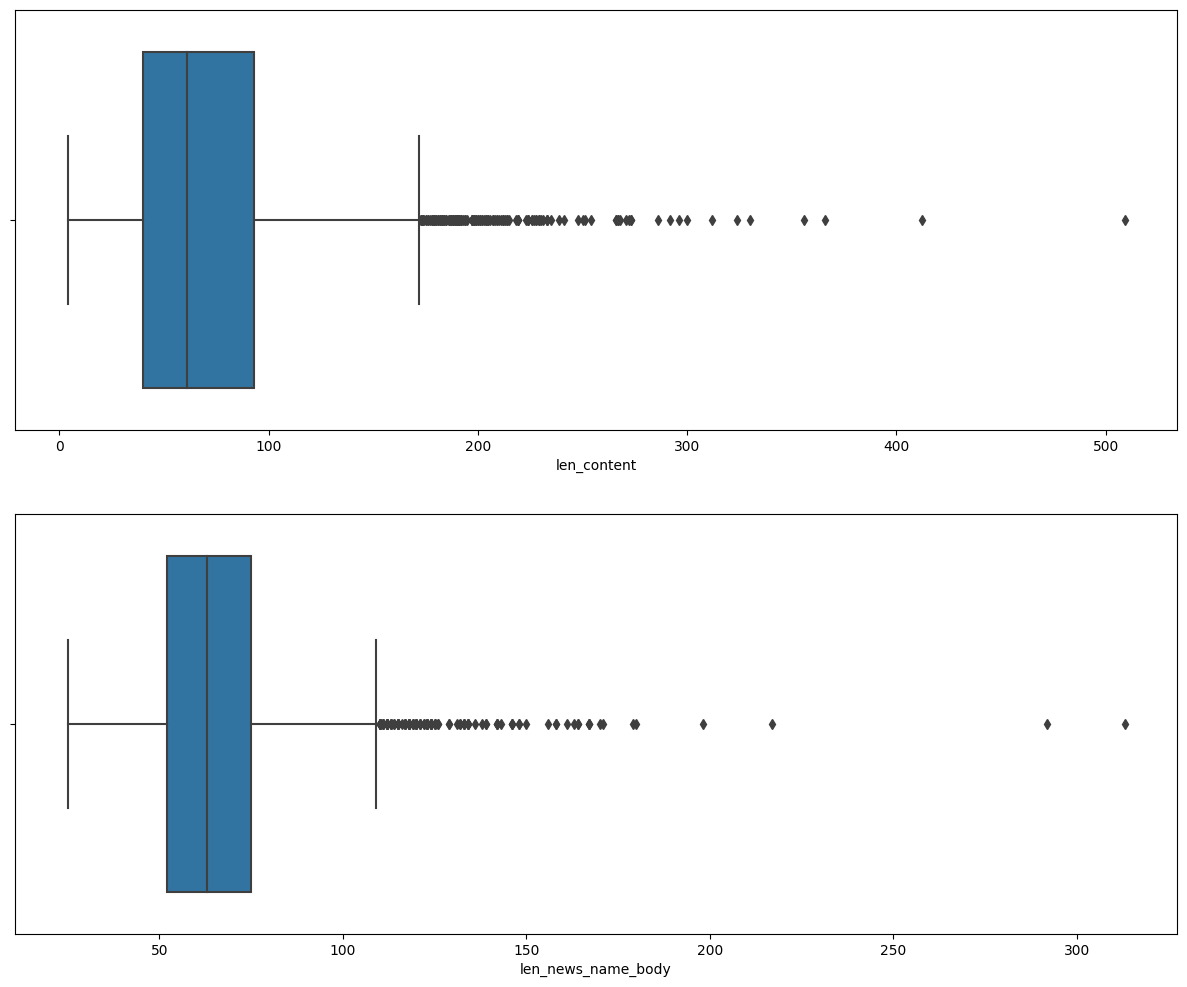

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

sns.boxplot(ax=axes[0], x='len_content', data=data)
sns.boxplot(ax=axes[1], x='len_news_name_body', data=data)

In [ ]:
train.to_csv('train.csv', index=False, encoding='utf-8')
eval.to_csv('eval.csv', index=False, encoding='utf-8')
test.to_csv('test.csv', index=False, encoding='utf-8')

### Новости, посвященные какому-то событию

#### Fine-tuning модели mbart-large-cc25

In [ ]:
SEED = 3
lang = 'ru_RU'
set_seed(SEED)

In [ ]:
dataset = load_dataset("csv", data_files={'train': 'train.csv', 'eval': 'eval.csv', 'test': 'test.csv'})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-4584608139cd8e97/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset['train'][0]

{'match_id': 18925,
 'news_id': 7274151,
 'name': 'Россия. Премьер-лига',
 'team1': 'Локомотив',
 'team2': 'Химки',
 'news_name_body': 'Дюрица получил травму в игре с «Химками» & Защитник «Локомотива» Ян Дюрица получил травму в игре 1-го тура с «Локомотивом», сообщает корреспондент Sports.ru Инна Герман. В конце первого тайма его заменил Фининьо. Дюрица покинул поле и ушел в подтрибунное помещение, сильно прихрамывая и с ледяным компрессом на правой ноге. Тяжесть травмы словака пока неизвестна.',
 'content': '0 минута. Добрый день! Sports.ru поздравляет всех, кто прошедшей зимой с нетерпением считал дни до старта российской премьер-лиги. Наша первая текстовая трансляция чемпионата 2009 поможет Вам проследить за событиями, который произойдут на стадионе "Локомотив", где одноименная команда принимает гостей из "Химок". 0 минута. "Локомотив" зимой старался стать лучше. В состав были влиты Ян Дюрица, Станислав Иванов, Олег Кузьмин и Томислав Дуймович. Все фамилии, как говорится, на слуху. 

In [ ]:
model_name = "facebook/mbart-large-cc25"

config = transformers.AutoConfig.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, config=config)

In [ ]:
model.config.decoder_start_token_id = tokenizer.convert_tokens_to_ids(lang)

In [ ]:
tokenizer.src_lang = lang
tokenizer.tgt_lang = lang

# Для mbart нужен токен языка
forced_bos_token_id = (tokenizer.lang_code_to_id[lang])

model.config.forced_bos_token_id = forced_bos_token_id

In [ ]:
text_column = 'content'
summary_column = 'news_name_body'

In [ ]:
max_source_length = 512
max_target_length = 300
padding = 'max_length'
ignore_pad_token_for_loss = True

In [ ]:
def preprocess_function(examples):
  inputs, targets = [], []

  for i in range(len(examples[text_column])):
      if examples['name'][i] and examples['team1'][i] and examples['team2'][i] and examples[text_column][i] and examples[summary_column][i]:
          inputs.append('</s>'.join([examples['name'][i], examples['team1'][i], examples['team2'][i], examples[text_column][i]]))
          targets.append(examples[summary_column][i])

  model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

  labels = tokenizer(text_target=targets, max_length=max_target_length, padding=padding, truncation=True)

  # Для игнорирования паддинга в loss
  if padding == "max_length" and ignore_pad_token_for_loss:
      labels["input_ids"] = [
          [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
      ]

  model_inputs["labels"] = labels["input_ids"]

  return model_inputs

In [ ]:
train_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=2,
    remove_columns=['match_id', 'news_id', 'name', 'team1', 'team2', 'content',  'news_name_body'],
    )

Map (num_proc=2):   0%|          | 0/3373 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/488 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/149 [00:00<?, ? examples/s]

In [ ]:
# Data collator
label_pad_token_id = -100
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

In [ ]:
# Метрика
metric = evaluate.load("rouge")

In [ ]:
def postprocess_text(preds, labels):
  preds = [pred.strip() for pred in preds]
  labels = [label.strip() for label in labels]

  # rougeLSum ожидает новую строку после каждого предложения
  preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
  labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

  return preds, labels

In [ ]:
def compute_metrics(eval_preds):
  preds, labels = eval_preds
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  if ignore_pad_token_for_loss:
      labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

  result = metric.compute(predictions=decoded_preds, references=decoded_labels, tokenizer=lambda x: x.split())
  result = {k: round(v * 100, 4) for k, v in result.items()}
  prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
  result["gen_len"] = np.mean(prediction_lens)
  return result

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir=".",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=16,
    gradient_checkpointing=True,
    optim="adafactor",
    logging_steps=25,
    evaluation_strategy='epoch',
    save_strategy="epoch",
    load_best_model_at_end=True,
    predict_with_generate=True
    )

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset['train'],
    eval_dataset=train_dataset['eval'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
    )

train_result = trainer.train()

You're using a MBartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
0,1.778300,1.522030,27.607600,13.136600,23.075900,26.396100,117.809426
1,1.423700,1.331492,35.897900,18.192100,30.583500,34.006600,127.040984
2,1.307700,1.300480,35.902600,18.269100,30.461200,33.870800,133.075820


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


In [ ]:
trainer.save_model('/content/drive/MyDrive/RuSportSum/save_model')

#### Оценка качества настроенного mBART на тестовом наборе данных

In [ ]:
predict_results = trainer.predict(
    train_dataset['test'],
    metric_key_prefix="predict",
    max_length=max_target_length,
    num_beams=3
)
metrics = predict_results.metrics

In [ ]:
metrics

{'predict_loss': 1.256629228591919,
 'predict_rouge1': 36.3249,
 'predict_rouge2': 18.0167,
 'predict_rougeL': 30.4598,
 'predict_rougeLsum': 34.4117,
 'predict_gen_len': 130.4765100671141,
 'predict_runtime': 208.9392,
 'predict_samples_per_second': 0.713,
 'predict_steps_per_second': 0.182}

In [ ]:
predictions = []
if trainer.is_world_process_zero():
  if training_args.predict_with_generate:
    predictions = tokenizer.batch_decode(
        predict_results.predictions, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    predictions = [pred.strip() for pred in predictions]

In [ ]:
output_prediction_file = "generated_predictions.txt"
with open(output_prediction_file, "w", encoding='utf-8') as writer:
  writer.write("\n".join(predictions).encode('utf-8').decode("utf-8"))

In [ ]:
print('часть матча: ', dataset['test'][0]['content'])
print('оригинальная новость: ', dataset['test'][0]['news_name_body'])
print('предсказанная новость: ', predictions[0])

часть матча:  0 минута. "Химки" было приобрели у Нальчика Самсонова и Пилипчука, а потом игроки разонравились, но, поскольку две недели со дня продажи истекли, вернуть их обратно удалось лишь в аренду. Пилипчук сегодня не сыграет, а вот Олега стоит ждать на поле. 58 минута. Самсонов бежал по флангу и повредил себе ногу. Больно. 61 минута. Леандро объявился на газоне, меняя травмированного Самсонова. 67 минута. Tamazini, Самсонова унесли на носилках. Но вроде сейчас сам сидит и даже пледом укрывается.
оригинальная новость:  Самсонов получил травму в матче против «Химок» & Полузащитник нальчикского «Спартака» Олег Самсонов получил травму в матче 22-го тура против «Химок». На 58-й минуте игрок получил мяч на углу штрафной, пробросил его на фланг, ускорился и упал, схватившись за бедро. Самсонов не смог встать самостоятельно и покинул поле на носилках. В составе нальчикского «Спартака» его заменил Леандро. За онлайном матча «Химки» «Спартак» (Нальчик) вы можете следить здесь .
предсказанна

In [ ]:
print('часть матча: ', dataset['test'][1]['content'])
print('оригинальная новость: ', dataset['test'][1]['news_name_body'])
print('предсказанная новость: ', predictions[1])

часть матча:  0 минута. Всем привет. Продолжаем следить за матчами 25-го тура ЧР. "Локомотив" только что проиграл - значит у "Москвы" есть шанс достать железнодорожников в таблице. А у "Крыльев" сегодня дебютирует Юрий Газзаев. 51 минута. и гол!!! После того самого углового! Ян Коллер на опережение ногой "проткнул" мяч в ближний угол. И точно между ног голышеву, грустно обнимающему ближнюю штангу... 1:1. 66 минута. Коллер просит замену - а это значит, что мы увидим заслуженного "горожанина", экс-игрока сборной России - Романа Адамова. 67 минута. Адамов вместо Коллера. Кажется, чех "дернул" бедро. 76 минута. ПЕНАЛЬТИ! Игорь Егоров ставит третий пенальти! На этот раз совершенно необоснованный, осмелюсь заявить.
оригинальная новость:  Коллер получил повреждение в матче с «Москвой» & Нападающий  «Крыльев Советов» Ян Коллер получил травму в матче 25-го тура премьер-лиги против «Москвы». Он дернул мышцу задней поверхности бедра. На 68-й минуте чеха заменил Роман Адамов. Подробную статистику 

In [ ]:
print('часть матча: ', dataset['test'][2]['content'])
print('оригинальная новость: ', dataset['test'][2]['news_name_body'])
print('предсказанная новость: ', predictions[2])

часть матча:  0 минута. Привет! Хотели было поведать вам о том, как динозавры, на днях вылупившиеся в подтаявших льдах Гренландии, научились играть в футбол и теперь мечтают выиграть Кубок УЕФА, но тут намечается гораздо более увлекательное зрелище - "Спартак Нальчик" принимает "Рубин"!
оригинальная новость:  Петр Быстров получил повреждение спины в матче с нальчикским «Спартаком» & Полузащитник «Рубина» Петр Быстров получил повреждение спины в первом тайме матча второго тура премьер-лиги против нальчикского «Спартака» (0:0), и поэтому не смог сыграть во втором тайме. «Удар по спине был болезненным, но гладкому бегу это не мешало. Проблема в другом резко ускоряться и тормозить я не мог. Все это давалось через боль, поэтому в перерыве пришлось попросить замену», приводит слова футболиста «Спорт-Экспресс» . Подробную статистику матча нальчикского «Спартака» с «Рубином» можно посмотреть здесь .
предсказанная новость:  «Спартак» Нальчик – «Рубин». Нальчикцы пропустили первый мяч в чемпиона